This notebook is intended to demonstrate that the solution of the time-independent Schrödinger equation
allows to easily calculate the time evolution of an arbitrary initial state.

Specifically, the time-independent Schrödinger equation is given by the eigenvalue problem
$$\hat{H}\varphi(r) = E\varphi(r),$$
were $\phi$ denotes the eigenstates (eigenfunctions) and E the eigenvalues (eigenenergies). Having cracked this problem, the solution of the time-dependent Schrödinger equation then reads
$$\Psi(r,t) = \sum_n a_n \varphi_n(r) e^{-i E_n t / \hbar},$$
where $n$ enumerates the eigenstates and -energies. The coefficients $a_n$ are obtained by projecting the initial condition $\Psi(r,t=0) = \Psi_0$ onto the eigenstates
$$ a_n = \langle \Psi_0 | \varphi \rangle,$$
where $\langle . | . \rangle$ denotes the inner product of the considered Hilbert space. Note that the temporal evolution of the probability density $|\Psi|^2$ is entirely determined by the interference of the complex exponentials. Hence, only initial conditions, which excite multide modes $\phi_n$ will yield non-stationary dynamics.

The example at hand is the particle in a one-dimensional box of length $L$, i.e., in an infinite potential well, where the potential is given by
$$V(x) = \begin{cases}
0, & -\tfrac{L}{2} < x <\tfrac{L}{2},\\
\infty, & \text{otherwise,}
\end{cases}$$
The solution of the eigenvalue problem is straightforward and yields the eigenenergies
$$E_n=\hbar \omega_n=\frac{n^2 \pi^2 \hbar^2}{2 m L^2}$$
with $n = 1,2,...$ and the eigenfunctions
$$ \psi_n (x) = \begin{cases}
\sqrt{\frac{2}{L}} \sin(k_nx) \quad{} \text{for } n \text{ even} \\
\sqrt{\frac{2}{L}} \cos(k_nx) \quad{} \text{for } n \text{ odd}.
\end{cases}$$
where $k_n = n \pi / L$ is the quantized wave vector.

In [1]:
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

#######################################
### function definitions
#######################################

### discretized k_n
def get_k(n,L):
    return n * np.pi / L

### solutions to the time-independent Schroedinger equation
def phi(x,n,L):
    if n%2 == 0:
        return np.sqrt(2./L) * np.sin( get_k(n,L) * x)
    else:
        return np.sqrt(2./L) * np.cos( get_k(n,L) * x)

### dispersion relation
def omega(n,L,m):
    return get_k(n,L)**2 * constants.hbar / m

### calculate a_n by projecting the initial condition onto the eigenfunctions phi_n
def get_a_n(init, phi_matrix, dx):
    n_max = phi_matrix.shape[0]
    a_n = np.zeros(n_max, dtype = complex)
    for n in range(n_max):
        a_n[n] = init @ phi_matrix[n] * dx
    return a_n
        
### calculate the time evolution of the wavefunction Psi.
def get_Psi(init, a_n_max, tmax, t_nmax):
    
    x_nmax = init.size
    t = np.linspace(0,t_max,t_nmax)

    ### fill phi matrix
    phi_matrix = np.zeros((a_n_max,x_nmax))
    for n in range(a_n_max):
        phi_matrix[n] = phi(x,n+1,L) #no n=1 state
    
    ### project intitial condition onto the modes
    a_n = get_a_n(init,phi_matrix,dx)
    
#     #uncomment to plot
#     plt.semilogy(np.abs(a_n), 'o')
#     plt.xlabel('$n$')
#     plt.ylabel('$a_n$')
#     plt.show()
    
    ### calculate the time evolution of the wavefunction
    Psi = np.zeros((t_nmax,x_nmax), dtype=complex)
    for t_n in range(t_nmax):
        psi = np.zeros(x_nmax, dtype=complex)
        for n in range(a_n_max):
            psi += a_n[n] * phi_matrix[n] * np.exp(-1.j * omega(n,L,m) * t[t_n])
        Psi[t_n] = psi
        
    return Psi

Simulation of the time evolution of particle, which has been measured at the position $x_0$ with an uncertainty $\sigma$ and a mean wave vector $k_0$.

The number of spatial discretization points x_nmax should be chosen, such that the largest mode (eigenfunction) still fullfils the Nyquist limit.

Make sure to include a sufficient number of modes $\phi_n$, by plotting the coefficients $a_n$ (uncomment the respective lines above) and verifying that they become negligible for larger $n$.

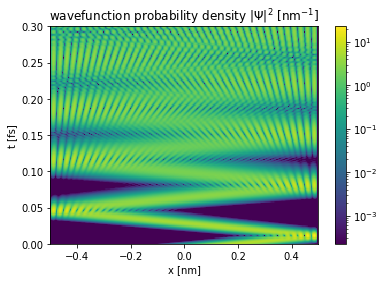

In [2]:


### model parameters
L = 1.0e-9 # 1nm
m = constants.m_e # electron mass

#### spatial discretization
x_nmax = 500

### number of modes
a_n_max = 250

### integration time and number of samples
t_max = 0.3e-15 # e-15 -> femto seconds
t_nmax = 200

### Gaussian initial condition paramters ###
x_0 = L/5 #mean
sigma = L/15 #width
k0 = get_k(40,L) #mean wave vector

### calc initial condition###
x = np.linspace(-L/2.,L/2.,x_nmax+1, endpoint = True) #spatial grid
dx = L/x_nmax #spatial discretization length

init = np.exp(-0.25 * (x-x_0)**2 / sigma**2 ) * np.exp(1.j*k0*x)
norm = (np.sum( np.abs(init)**2 )*dx)
init /= np.sqrt(norm)
# print(np.sum(np.abs(init)**2)*dx) # make sure the norm works


from matplotlib.colors import LogNorm

Psi = get_Psi(init, a_n_max, t_max, t_nmax)
Psi2 = np.abs(Psi)**2

extent_ar = [-L/2*1e9, L/2*1e9, 0*1e15,t_max*1e15]
plt.imshow(Psi2*1e-9, aspect='auto', interpolation='none', origin='lower', norm=LogNorm(vmin=1e-5*Psi2.max()*1e-9), extent = extent_ar)
plt.xlabel('x [nm]')
plt.ylabel('t [fs]')
plt.title(r'wavefunction probability density $|\Psi|^2$ [nm$^{-1}$]')
plt.colorbar()
plt.show()



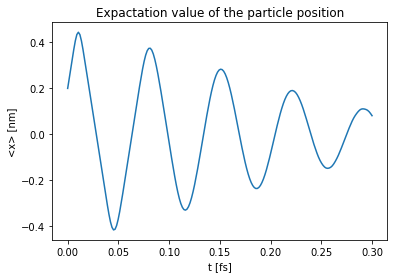

In [3]:
x_mean = np.sum(Psi2 * x, axis=1)*dx
plt.plot(np.linspace(0,t_max,t_nmax)*1e15,x_mean*1e9)
plt.title('Expactation value of the particle position')
plt.xlabel('t [fs]')
plt.ylabel('<x> [nm]')
plt.show()

<IPython.core.display.Javascript object>


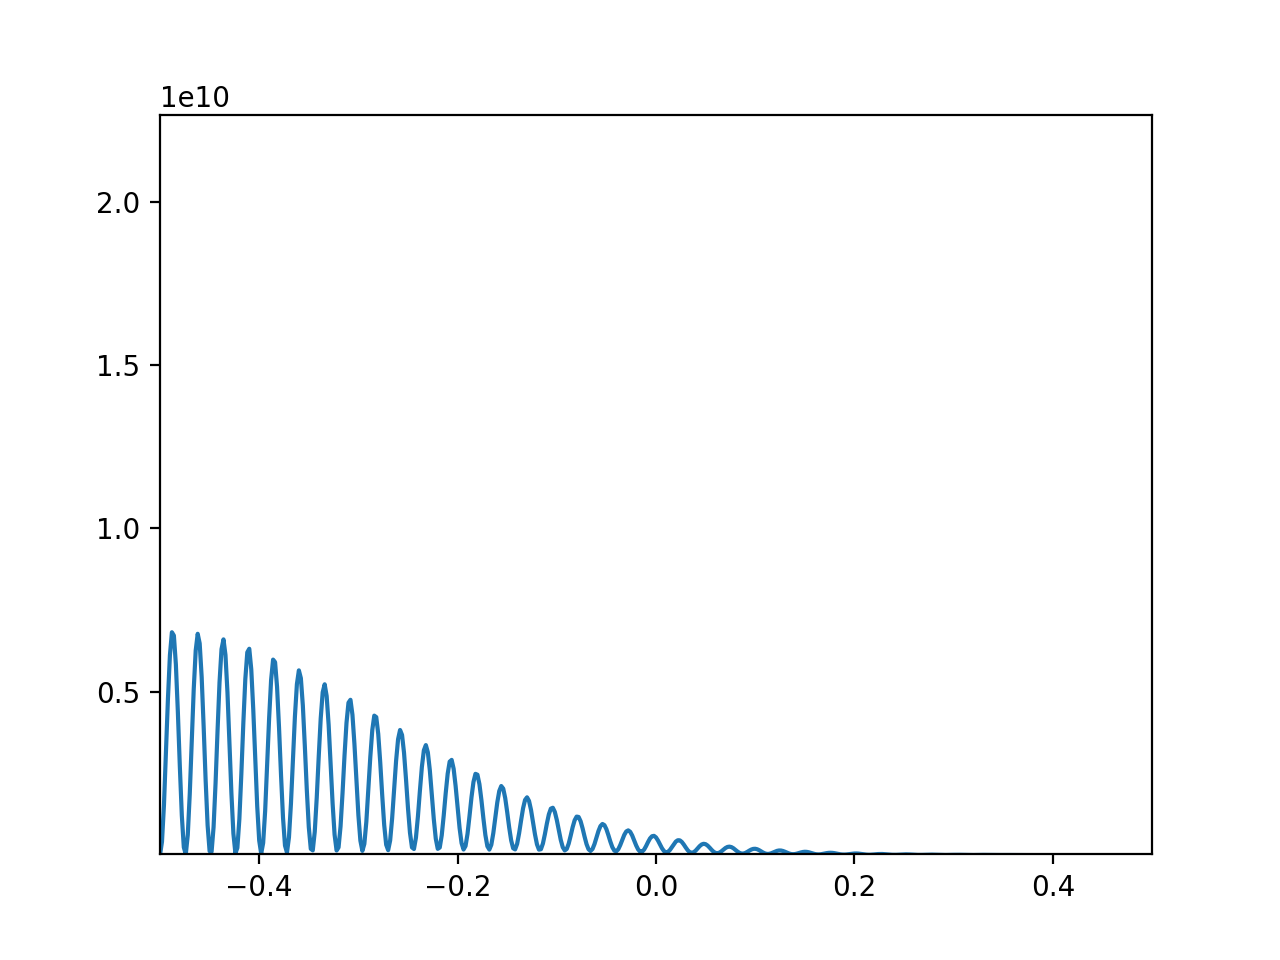

In [4]:
#######################################
### video of the time evolution
#######################################

%matplotlib notebook

from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

line, = ax.plot([]) 

ax.set_xlim(x.min()*1e9, x.max()*1e9)
ax.set_ylim(1e-3*Psi2.max(),Psi2.max())

def animate(frame_num):
    line.set_data((x*1e9, Psi2[frame_num]))
    return line

anim = FuncAnimation(fig, animate, frames=t_nmax, interval=10)

plt.show()